In [3]:
# Autoreload extension
%load_ext autoreload
%autoreload 2

from svcj.dl.train import train
from svcj.dl.simulator import simulate_returns
from svcj.dl.predict import predict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
model = train(
    arch="cnn_ficura",                                # renamed from cnn_svjd (compatibility still works)
    model_type="svj",                           # choose "sv", "svj", or "svcj"
    seq_len=24*90,                            
    epochs=100,                                
    batch_size=100,                             
    lr=1e-3,                                   
    weight_decay=1e-4,                         
    n_samples=50_000,                          
    val_split=0.10,                            
    early_stop_patience=10,                    
    mixed_precision=True,                      
    logdir="/home/pduce/sbt/svcj/data/models/sv_model",  # suggested: include model type in path
    device="cuda",                             
    num_workers=12,
    mu_mode="devol"
)

15:32:19 [INFO] ==== SV-family Trainer started (SVJ) ====
15:32:19 [INFO] Args: arch=cnn_ficura seq_len=2160 epochs=100 batch=100 n_samples=50000 lr=0.001 wd=0.0001 val_split=0.1 patience=10 mp=True load_ckpt=False
15:32:19 [INFO] → device: cuda
15:32:19 [INFO] Dataset ready · train=45000, val=5000
15:34:51 [INFO] Input μ = 0.000185, σ = 0.01828
15:38:43 [INFO] Target μ/σ (train) and μ_val (val) computed
/home/pduce/sbt/svcj/.venv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/home/pduce/sbt/svcj/src/svcj/dl/train.py:185: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler  = torch.cuda.amp.GradScaler(enabled=mixed_precision)
15:38:43 [INFO] training from scratch
epoch 1/100 · train:   0%|          | 0/450 [00:00<?, ?it/s]/home/pduce/sbt/svcj/src/svcj/dl/train.py:209: Fu

          true       pred
mu        0.40   0.358623
v_long    0.01   3.328053
beta      0.01   0.597428
gamma     0.50   0.528803
mu_j      0.10   0.420387
sigma_j   0.01   0.225196
lambda   10.00  10.828854


/home/pduce/sbt/svcj/src/svcj/dl/predict.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


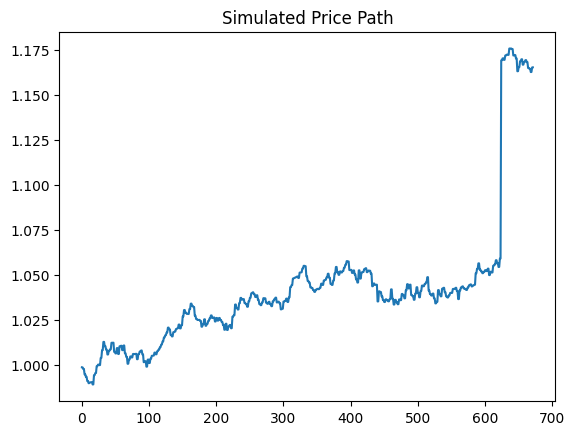

In [60]:
import pandas as pd
import torch

from svcj.dl.predict import predict
from svcj.dl.config  import get_param_order
from svcj.dl.simulator import simulate_returns  # returns (r, v) :contentReference[oaicite:0]{index=0}:contentReference[oaicite:1]{index=1}

# ─── 1) True parameters and simulation ────────────────────────────
true_params = [0.4, 0.01, 0.01, 0.5,0.1,0.01,10]  # μ, v_long, β, γ
steps = 672
rets, _ = simulate_returns(params=true_params,
                           steps=steps,
                           model_type="svj")

# ─── 2) Prediction ────────────────────────────────────────────────
# make sure your model has been saved with the matching `mu_mode`
SEQ_LEN = 672

mu_train=0.0001
σ_train=0.0005622

est = predict(
    model_path   = "/home/pduce/sbt/svcj/data/models/sv_model/ckpt/best.pt",
    arch         = "cnn_ficura",
    model_type   = "svj",
    device       = "cuda" if torch.cuda.is_available() else "cpu",
    return_series= rets,        # full (steps,) array
    seq_len      = SEQ_LEN,     # must match training
    agg          = "mean",    # or "mean" if you prefer
    mu_mode      = "devol", # or "devol",
    TRAIN_X_MEAN = mu_train,
    TRAIN_X_STD  = σ_train
)

# ─── 3) Tabulate & plot ───────────────────────────────────────────
param_order = get_param_order("svj")
pred = pd.Series(est, index=param_order, name="pred")
true = pd.Series(true_params, index=param_order, name="true")

# cumulative‐return plot + predicted vs. true table
ax = (pd.Series(rets).add(1).cumprod()
         .plot(title="Simulated Price Path"))
print(pd.concat([true, pred], axis=1))


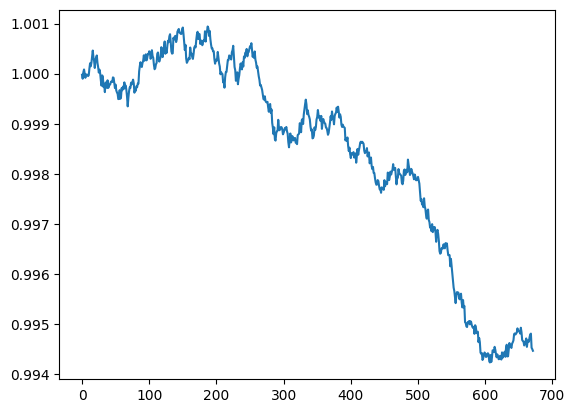